### Install Libraries


In [32]:
# Install Libraries (Install if needed)
# !apt-get install -y tesseract-ocr
# !pip install pytesseract
# !pip install torch torchvision transformers tqdm
# !pip install tqdm
# !pip install tensorflow matplotlib opencv-python-headless
# !pip install easyocr
# !pip install pyarrow
# !pip install fastparquet
# !pip install datasets
# !pip install evaluate
# !pip install jiwer
# !pip install accelerate  # Accelerate Training

### Import Libraries

In [33]:
# --- SYSTEM AND FILE HANDLING ---
import os
import random
from zipfile import ZipFile
from shutil import copyfile

# --- DATA MANIPULATION ---
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- IMAGE PROCESSING ---
import cv2
from PIL import Image, ImageStat
import pytesseract
from jiwer import cer, wer

# --- DATA VISUALIZATION ---
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from tqdm import tqdm

# --- DEEP LEARNING LIBRARIES ---
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor

# --- HUGGING FACE TRANSFORMERS ---
from transformers import (
    TrOCRProcessor,
    VisionEncoderDecoderModel,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    AdamW,
    get_scheduler,
)
from datasets import Dataset, DatasetDict
import evaluate  # Correctly replace load_metric

# --- WARNINGS SUPPRESSION ---
import warnings
import logging

# Suppress unnecessary warnings and info messages
warnings.filterwarnings("ignore")
logging.getLogger("transformers").setLevel(logging.ERROR)

### Collect and Load Data

In [34]:
# --- MOUNT GOOGLE DRIVE ---
from google.colab import drive

print("Mounting Google Drive...")
drive.mount('/content/drive')

google_drive_path = "/content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/"
print("Available files:", os.listdir(google_drive_path))

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Available files: ['TextOCR Dataset.zip', 'TextOCR Dataset.zip (Unzipped Files)', 'TextOCR_test_Images_filtered.zip', 'Model_TcOCR_Final.ipynb', 'Model_TcOCR_Final.pdf']


### Understanding Data

In [35]:
# Correct path to the dataset
google_drive_zip_path = "/content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip"
unzipped_folder = "/content/unzipped_dataset"


def unzip_dataset(zip_path, extract_to):
    if os.path.exists(zip_path):
        print(f"Extracting dataset from {zip_path}...")

        # Open the zip file
        with ZipFile(zip_path, 'r') as zip_ref:
            # Get the list of files to extract
            file_list = zip_ref.namelist()

            # Create a progress bar for extraction
            for file in tqdm(file_list, desc="Extracting", unit="file"):
                zip_ref.extract(file, extract_to)

        print(f"Dataset extracted to {extract_to}")
    else:
        raise FileNotFoundError(f"Zip file not found at {zip_path}")


# Unzip the dataset with progress bar
unzip_dataset(google_drive_zip_path, unzipped_folder)

# List the unzipped dataset
print("\n----- Top Level Files -----")
!ls /content/unzipped_dataset

# Optionally, find all directories within the unzipped dataset
print("\n----- Dataset Directory -----")
!find /content/unzipped_dataset -type d

Extracting dataset from /content/drive/My Drive/Colab Notebooks/AAI-521-Computer Vision Dataset/TextOCR Dataset.zip...


Extracting: 100%|██████████| 25124/25124 [01:36<00:00, 261.57file/s]

Dataset extracted to /content/unzipped_dataset

----- Top Level Files -----
annot.csv  annot.parquet  img.csv  img.parquet	TextOCR_0.1_train.json	train_val_images



----- Dataset Directory -----
/content/unzipped_dataset
/content/unzipped_dataset/train_val_images
/content/unzipped_dataset/train_val_images/train_images


In [36]:
# ~~~~~ Top Level Files ~~~~~ Data Sample
# Correct paths to dataset files and folders
base_path = "/content/unzipped_dataset"
csv_files = [os.path.join(base_path, "annot.csv"), os.path.join(base_path, "img.csv")]
parquet_files = [os.path.join(base_path, "annot.parquet"), os.path.join(base_path, "img.parquet")]
json_file = os.path.join(base_path, "TextOCR_0.1_train.json")
image_folder = os.path.join(base_path, "train_val_images/train_images")

# Prepare a dictionary to store file samples for visualization
file_samples = {}

# Load and collect CSV file samples
for file in csv_files:
    try:
        df = pd.read_csv(file)
        file_samples[file] = df.head()  # Collect first 5 rows
    except Exception as e:
        file_samples[file] = pd.DataFrame({"Error": [str(e)]})  # Collect error as DataFrame

# Load and collect Parquet file samples
for file in parquet_files:
    try:
        df = pd.read_parquet(file)
        file_samples[file] = df.head()  # Collect first 5 rows
    except Exception as e:
        file_samples[file] = pd.DataFrame({"Error": [str(e)]})  # Collect error as DataFrame

# Load and collect JSON file samples
try:
    with open(json_file, 'r') as f:
        data = json.load(f)
        # Convert first 5 keys and values to DataFrame
        json_sample = {k: data[k] for k in list(data.keys())[:5]}
        file_samples[json_file] = pd.DataFrame.from_dict(json_sample, orient='index', columns=['Value'])
except Exception as e:
    file_samples[json_file] = pd.DataFrame({"Error": [str(e)]})  # Collect error as DataFrame

# Load and collect image folder sample
try:
    image_sample = os.listdir(image_folder)[:5]
    file_samples[image_folder] = pd.DataFrame({"Images": image_sample})  # Convert filenames to DataFrame
except Exception as e:
    file_samples[image_folder] = pd.DataFrame({"Error": [str(e)]})  # Collect error as DataFrame

# Display DataFrame contents
for file_path, sample_df in file_samples.items():
    print(f"--- Sample from {file_path} ---")
    print(sample_df)

--- Sample from /content/unzipped_dataset/annot.csv ---
   Unnamed: 0                  id          image_id  \
0           0  a4ea732cd3d5948a_1  a4ea732cd3d5948a   
1           1  a4ea732cd3d5948a_2  a4ea732cd3d5948a   
2           2  a4ea732cd3d5948a_3  a4ea732cd3d5948a   
3           3  a4ea732cd3d5948a_4  a4ea732cd3d5948a   
4           4  a4ea732cd3d5948a_5  a4ea732cd3d5948a   

                            bbox  utf8_string  \
0   [525.83, 3.4, 197.64, 33.94]  Performance   
1  [534.67, 64.68, 91.22, 38.19]        Sport   
2  [626.95, 63.62, 96.52, 31.82]        Watch   
3  [577.4, 141.87, 147.13, 43.1]   ...period.   
4  [391.03, 163.9, 60.82, 38.65]            .   

                                              points     area  
0  [525.83, 3.4, 723.47, 7.29, 722.76, 36.99, 525...  6707.90  
1  [535.73, 64.68, 623.41, 67.51, 625.89, 102.87,...  3483.69  
2  [626.95, 63.62, 721.7, 63.62, 723.47, 95.44, 6...  3071.27  
3  [580.02, 143.61, 724.53, 141.87, 723.66, 184.9...  6341.30 

### Achieving Ground Truth

In [37]:
# --- Loading Annotations ---
json_path = "/content/unzipped_dataset/TextOCR_0.1_train.json"  # Path to JSON annotation file
annot_csv_path = "/content/unzipped_dataset/annot.csv"          # CSV annotations file
img_csv_path = "/content/unzipped_dataset/img.csv"              # Image metadata CSV
image_folder = "/content/unzipped_dataset/train_val_images/train_images"  # Folder with images

# Load JSON annotations
with open(json_path, "r") as f:
    json_data = json.load(f)  # Load the JSON annotations

# Load CSV annotations and image metadata
annot_df = pd.read_csv(annot_csv_path)  # Load annotations from CSV
img_metadata_df = pd.read_csv(img_csv_path)  # Load image metadata

# Merge CSV annotations and image metadata
merged_df = pd.merge(
    annot_df, img_metadata_df,
    left_on="image_id", right_on="id",
    how="inner"
)

# Add file paths to the merged DataFrame
merged_df["file_path"] = merged_df["file_name"].apply(
    lambda x: os.path.join(image_folder, x)
)

# --- Preparing Ground Truth Data ---
image_text_pairs = []

# Validate JSON structure and debug keys
if "imgs" in json_data and "anns" in json_data and "imgToAnns" in json_data:
    print("JSON keys are valid. Proceeding...")
else:
    print("JSON keys missing. Check JSON structure:")
    print(json_data.keys())

for img_id, metadata in json_data.get("imgs", {}).items():
    file_name = metadata.get("file_name", "")
    corrected_file_name = file_name.replace("train/", "")
    img_path = os.path.join(image_folder, corrected_file_name)

    if not os.path.exists(img_path):
        print(f"Image path not found: {img_path}")
        continue

    # Debugging the annotations linked to the image
    ann_ids = json_data.get("imgToAnns", {}).get(img_id, [])
    if not ann_ids:
        print(f"No annotations found for image ID: {img_id}")
        continue

    text_annotations = []
    for ann_id in ann_ids:
        annotation = json_data["anns"].get(ann_id, {})
        utf8_string = annotation.get("utf8_string", "")
        if not utf8_string:
            print(f"Annotation missing text for ID: {ann_id}")
        else:
            text_annotations.append(utf8_string)

    # Concatenate annotations
    full_text = " ".join(text_annotations)
    image_text_pairs.append({"image_path": img_path, "text": full_text})

if not image_text_pairs:
    print("No valid image-text pairs were found. Debug the JSON annotations further.")

# Convert to DataFrame
ground_truth_df = pd.DataFrame(image_text_pairs)

# Display a sample of the prepared ground truth data
print(ground_truth_df.head())

JSON keys are valid. Proceeding...
                                          image_path  \
0  /content/unzipped_dataset/train_val_images/tra...   
1  /content/unzipped_dataset/train_val_images/tra...   
2  /content/unzipped_dataset/train_val_images/tra...   
3  /content/unzipped_dataset/train_val_images/tra...   
4  /content/unzipped_dataset/train_val_images/tra...   

                                                text  
0  Performance Sport Watch ...period. . 400 300 1...  
1  400 Z 7 at nLa A. James LYNCH REAL ESTATE 781....  
2  CAOL ILA DISTILLERY 1996 GLE MALT SCOTCH WHISK...  
3                                     G-ATCO HUSKY +  
4  OUR NEIGHBORS, THE FRIENDS . . . 1 Muhomah . f...  


### Ground Truth Image Sample

In [38]:
def visualize_ground_truth(image_path, image_annotations):
    """
    Visualize the ground truth annotations (bounding boxes and text) on the image.
    """
    image = Image.open(image_path)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)

    for annotation in image_annotations:
        bbox = annotation["bbox"]  # [x, y, width, height]
        text = annotation["utf8_string"]

        # Draw bounding box
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor="red", facecolor="none"
        )
        ax.add_patch(rect)

        # Display text
        ax.text(
            bbox[0], bbox[1] - 10, text, fontsize=12, color="blue",
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", boxstyle="round,pad=0.3")
        )

    plt.axis("off")
    plt.show()

Visualizing before merging:


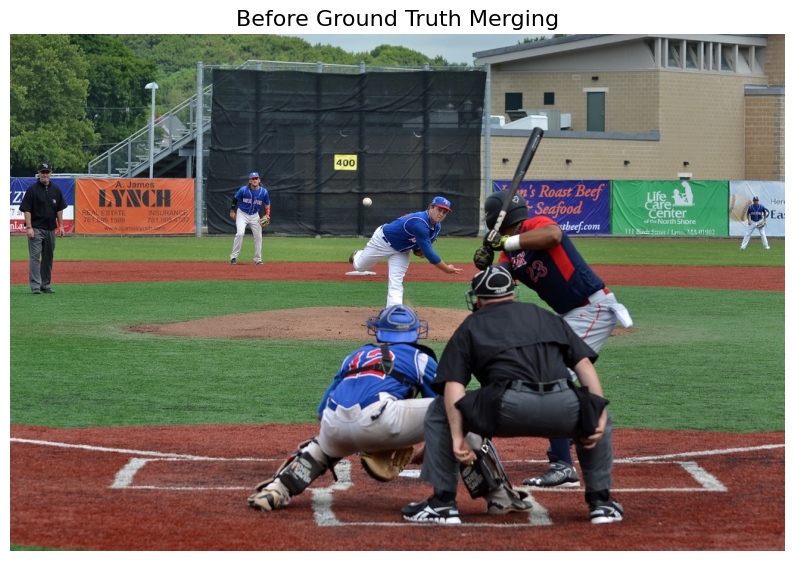


Visualizing after merging:


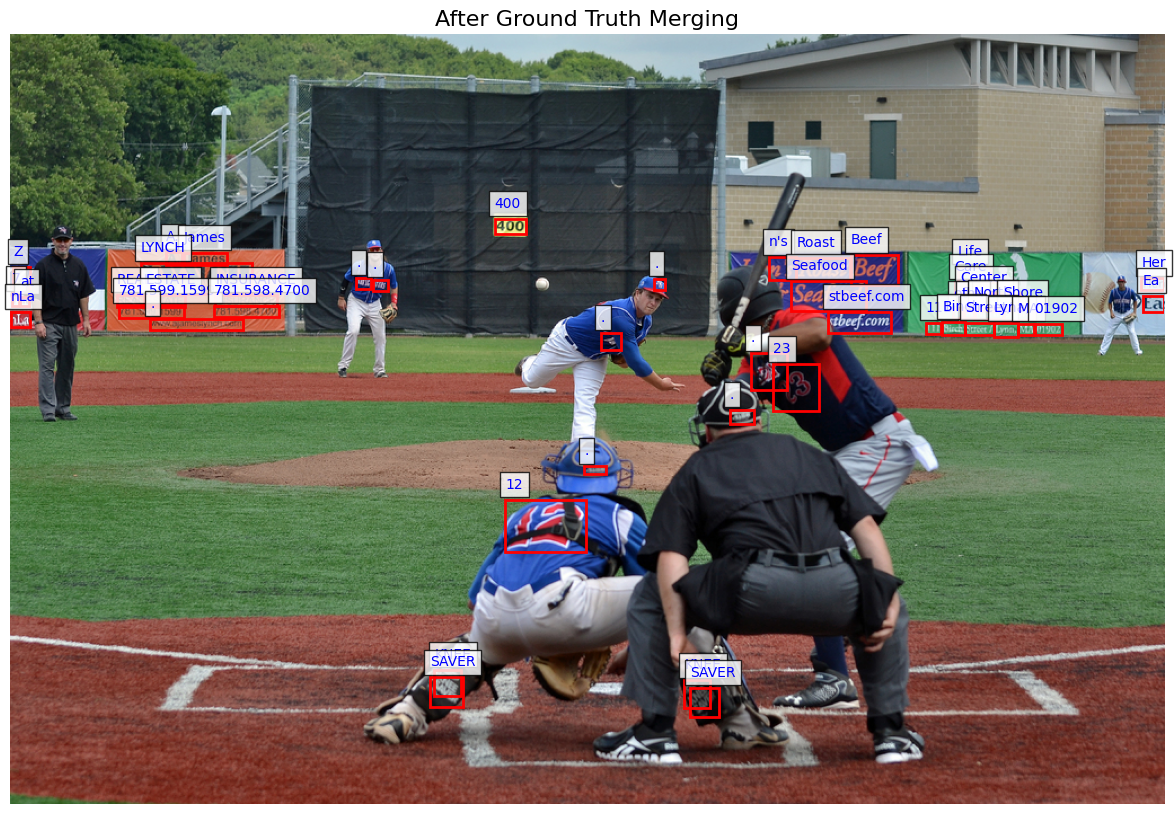

In [39]:
# Function to visualize the image before annotations
def visualize_before_merge(image_path):
    """
    Display the image without annotations (before merging).

    Args:
    - image_path (str): Path to the image file.
    """
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    # Load the image
    image = plt.imread(image_path)

    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title("Before Ground Truth Merging", fontsize=16)
    plt.axis('off')
    plt.show()

# Function to visualize the image after annotations
def visualize_after_merge(image_path, annotations):
    """
    Visualize the image with bounding boxes and labels (after merging).

    Args:
    - image_path (str): Path to the image file.
    - annotations (list of tuples): List of (label, bbox) tuples.
    """
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    # Load the image
    image = plt.imread(image_path)

    # Set up the plot
    fig, ax = plt.subplots(1, figsize=(15, 10))
    ax.imshow(image)

    # Add bounding boxes and labels
    for label, bbox in annotations:
        # Ensure bbox is a list (if stored as a string)
        if isinstance(bbox, str):
            bbox = eval(bbox)

        # Draw the bounding box
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor="red", facecolor="none"
        )
        ax.add_patch(rect)

        # Add the label above the bounding box
        ax.text(
            bbox[0], bbox[1] - 10, label, fontsize=10, color="blue",
            bbox=dict(facecolor="white", alpha=0.8)
        )

    plt.axis('off')
    plt.title("After Ground Truth Merging", fontsize=16)
    plt.show()


# File path for the specific image
image_path = "/content/unzipped_dataset/train_val_images/train_images/4bf43a7b2a898044.jpg"

# Define the annotations (label and bbox pairs)
annotations = [
    ("400", [429.44, 163.75, 27.52, 13.0]),
    ("Z", [2.52, 206.33, 14.29, 18.56]),
    ("7", [1.21, 229.65, 5.91, 11.33]),
    ("at", [8.11, 232.44, 8.54, 8.7]),
    ("nLa", [0.23, 246.23, 17.24, 12.81]),
    ("A.", [138.01, 192.86, 13.63, 11.33]),
    ("James", [153.61, 193.36, 38.43, 10.83]),
    ("LYNCH", [115.51, 202.88, 98.7, 27.43]),
    ("REAL", [94.32, 231.13, 24.47, 10.18]),
    ("ESTATE", [119.61, 231.29, 34.98, 10.18]),
    ("781.599.1599", [96.13, 240.32, 57.48, 11.17]),
    ("INSURANCE", [181.53, 230.96, 54.68, 9.69]),
    ("781.598.4700", [180.38, 240.65, 57.31, 10.02]),
    (".", [123.88, 252.48, 82.44, 9.52]),
    (".", [306.66, 215.53, 13.14, 9.85]),
    (".", [321.12, 217.66, 13.46, 10.18]),
    (".", [508.81, 382.92, 19.62, 6.98]),
    ("12", [439.01, 412.72, 71.5, 46.03]),
    (".", [571.09, 216.87, 9.19, 9.86]),
    (".", [656.64, 282.71, 32.03, 32.88]),
    ("23", [676.66, 292.43, 40.31, 41.17]),
    ("n's", [672.66, 197.52, 23.62, 19.94]),
    ("Roast", [696.93, 197.95, 47.67, 19.51]),
    ("Beef", [745.04, 195.79, 42.47, 26.65]),
    ("Seafood", [692.6, 218.97, 66.31, 25.79]),
    ("stbeef.com", [725.32, 245.84, 55.91, 18.85]),
    ("Life", [839.95, 205.97, 28.6, 16.47]),
    ("Care", [837.35, 219.41, 37.92, 14.73]),
    ("Center", [842.77, 229.59, 52.87, 15.82]),
    ("of", [836.05, 243.46, 9.32, 8.23]),
    ("the", [843.85, 243.68, 11.92, 8.01]),
    ("North", [854.47, 242.16, 27.08, 10.4]),
    ("Shore", [880.04, 242.38, 27.52, 10.61]),
    ("111", [811.92, 255.67, 13.63, 9.69]),
    ("Binch", [826.37, 255.02, 19.87, 11.33]),
    ("Street/", [846.89, 255.67, 25.46, 10.68]),
    ("Lyna,", [872.18, 256.16, 21.35, 12.16]),
    ("MA", [893.53, 256.66, 15.44, 10.01]),
    ("01902", [907.82, 256.49, 24.63, 10.18]),
    ("Her", [1003.13, 216.15, 19.87, 10.51]),
    ("Ea", [1004.11, 231.75, 18.72, 14.12]),
    (".", [637.9, 333.09, 21.34, 12.48]),
    ("KNEE", [597.52, 572.86, 23.19, 24.49]),
    ("SAVER", [602.72, 579.37, 26.01, 26.0]),
    ("KNEE", [375.82, 563.72, 23.62, 22.97]),
    ("SAVER", [371.92, 570.22, 29.25, 26.44]),
    (".", [523.51, 264.31, 17.74, 15.11]),
]

# Visualize the image before merging
print("Visualizing before merging:")
visualize_before_merge(image_path)

# Visualize the image after merging
print("\nVisualizing after merging:")
visualize_after_merge(image_path, annotations)

<i>**Ground Truth** was achieved by merging annotations, metadata, and image files into a unified dataset, ensuring each image was accurately linked with its bounding boxes, text annotations, and metadata such as dimensions and file paths. Using the JSON annotation file (TextOCR_0.1_train.json), annotation CSV (annot.csv), and image metadata (img.csv), I performed careful validation to confirm alignment between image_path, utf8_string (text annotations), and bbox (bounding box coordinates). For example, in the image "4bf43a7b2a898044.jpg," annotations include bounding boxes for text such as "400," "Seafood," and "KNEE SAVER," each accurately positioned to match its visual location. This visual linkage ensures a direct association between the image and its textual content, aiding in effective training and evaluation of the OCR model. Ground truth is crucial as it provides the reference data for metrics like Character Error Rate (CER) and Word Error Rate (WER) and enables the visualization of annotated images to address issues like missing or misaligned annotations. High-quality ground truth also enhances the model's learning process by establishing reliable text-image mappings and supports the refinement of preprocessing to maintain alignment between input data and expected outputs.</i>

### Display Data Images

Displaying the first 20 images from the dataset...


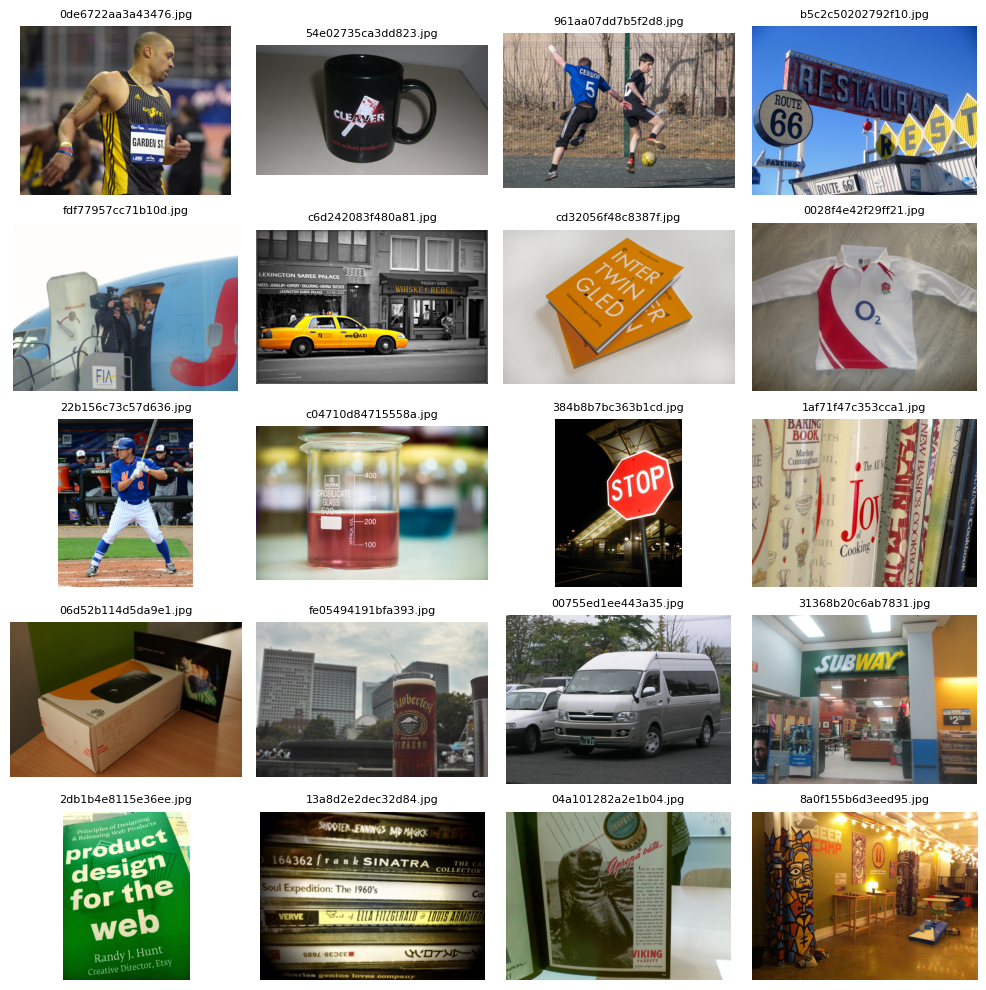

In [40]:
# Update the folder path to the correct image directory
unzipped_folder = "/content/unzipped_dataset/train_val_images/train_images"


def display_sample_images(folder, num_images=20):
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(valid_extensions)]
    image_files = image_files[:num_images]  # Limit to the first `num_images`

    if not image_files:
        print("No images found in the folder.")
        return

    # Display images in a grid
    plt.figure(figsize=(10, 10))
    for i, image_name in enumerate(image_files, start=1):
        image_path = os.path.join(folder, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
            plt.subplot(5, 4, i)  # Create a grid of 5 rows and 4 columns
            plt.imshow(image)
            plt.title(image_name, fontsize=8)
            plt.axis('off')
        else:
            print(f"Unable to read image: {image_name}")
    plt.tight_layout()
    plt.show()


# Display the first 20 images
print("Displaying the first 20 images from the dataset...")
display_sample_images(unzipped_folder)

### Data Cleaning

Processing Images: 100%|██████████| 25119/25119 [34:23<00:00, 12.17image/s]



Total images processed: 25119
Total OCR-ready images saved in '/content/test_images': 21266
Total non-OCR-ready images saved in '/content/disposed_images': 3853
Visualizing first 10 OCR-ready images from /content/test_images...


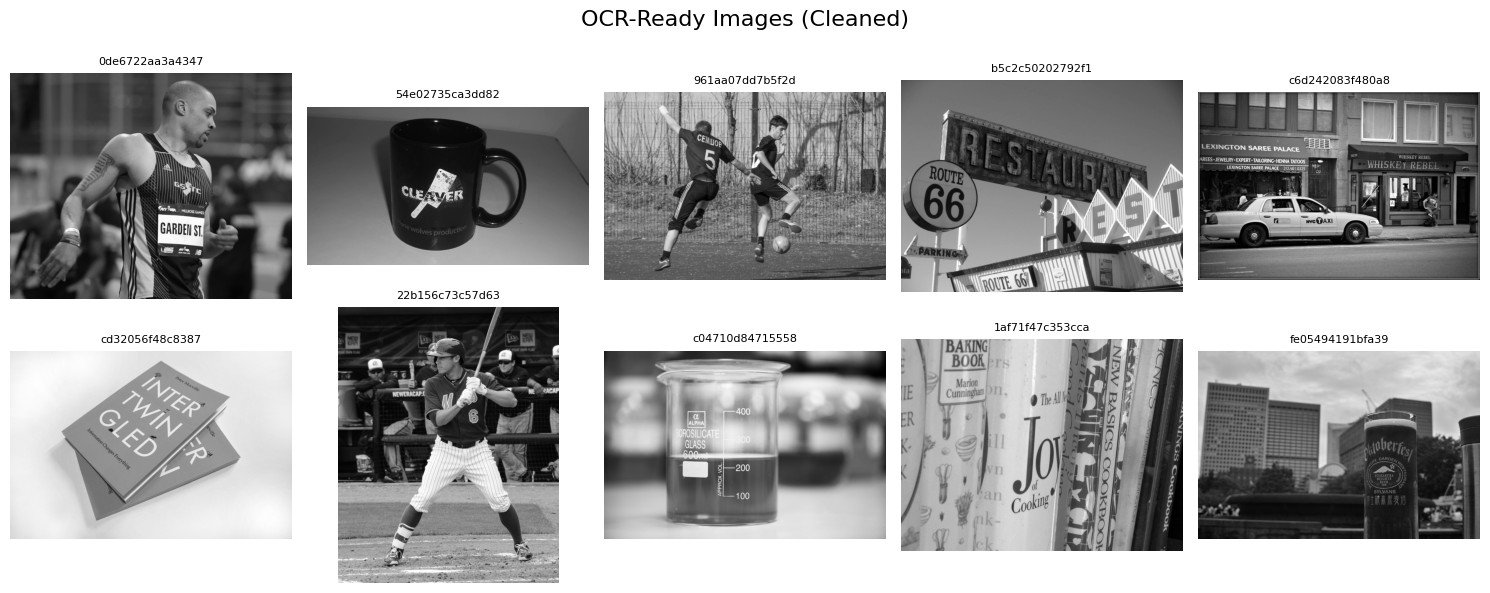

Visualizing first 10 non-OCR-ready images from /content/disposed_images...


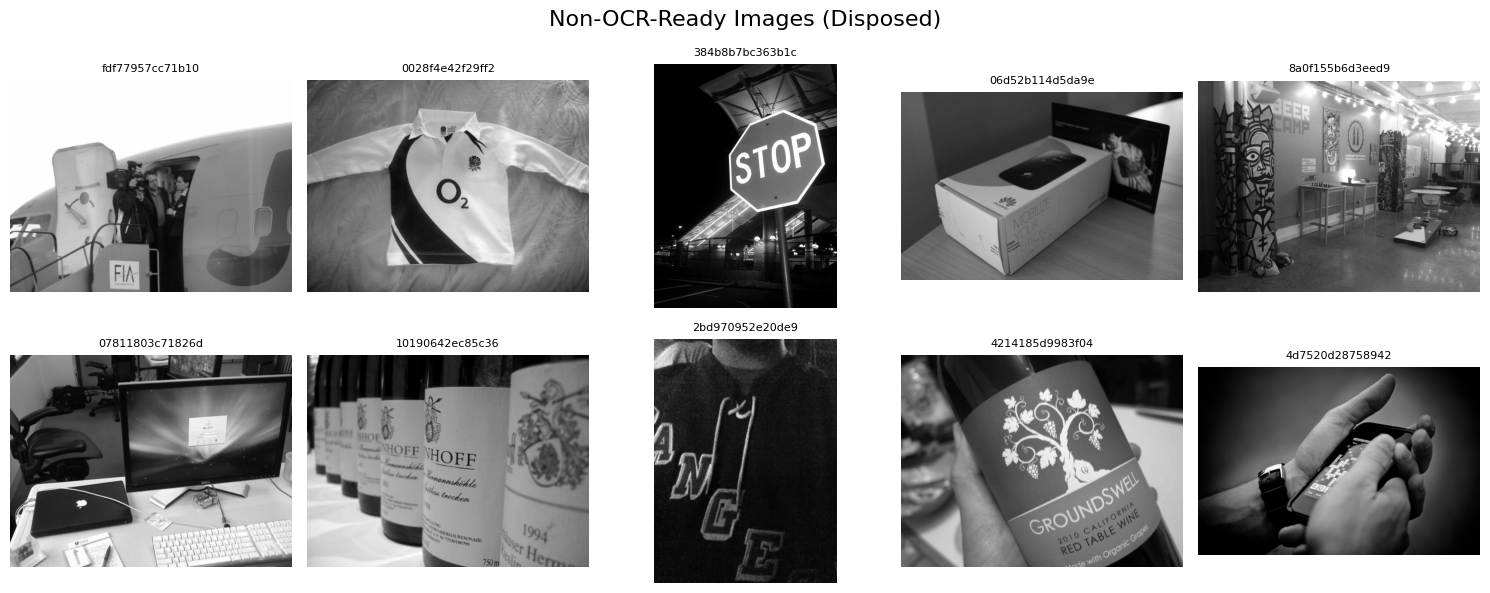

In [41]:
# Thresholds for quality checks
BRIGHTNESS_THRESHOLD = 50
CONTRAST_THRESHOLD = 20
SHARPNESS_THRESHOLD = 100

# Paths for input and output folders
input_folder = "/content/unzipped_dataset/train_val_images/train_images"
ocr_ready_folder = "/content/test_images"  # Folder for OCR-ready images
non_ocr_ready_folder = "/content/disposed_images"  # Folder for non-OCR-ready images
os.makedirs(ocr_ready_folder, exist_ok=True)  # Ensure OCR-ready folder exists
os.makedirs(non_ocr_ready_folder, exist_ok=True)  # Ensure non-OCR-ready folder exists

# Functions for image quality evaluation
def calculate_brightness(image):
    """Calculate brightness of an image."""
    pil_image = Image.fromarray(image)
    stat = ImageStat.Stat(pil_image)
    return stat.mean[0]

def calculate_contrast(image):
    """Calculate contrast of an image."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray.std()

def calculate_sharpness(image):
    """Calculate sharpness of an image."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def contains_text(image_path):
    """Check if an image contains text using Tesseract OCR."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    text = pytesseract.image_to_string(image)
    return len(text.strip()) > 0

# Function to clean and categorize images
def clean_images(input_folder, ocr_ready_folder, non_ocr_ready_folder):
    valid_images = []
    non_ocr_ready_images = []

    for image_name in tqdm(os.listdir(input_folder), desc="Processing Images", unit="image"):
        image_path = os.path.join(input_folder, image_name)
        if not image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            continue

        # Read and evaluate the image
        image = cv2.imread(image_path)
        if image is None:
            continue  # Skip unreadable images

        try:
            # Calculate quality metrics
            brightness = calculate_brightness(image)
            contrast = calculate_contrast(image)
            sharpness = calculate_sharpness(image)

            # Check if the image meets OCR readiness criteria or contains text
            if (
                brightness >= BRIGHTNESS_THRESHOLD and
                contrast >= CONTRAST_THRESHOLD and
                sharpness >= SHARPNESS_THRESHOLD
            ) or contains_text(image_path):
                # Save OCR-ready image
                copyfile(image_path, os.path.join(ocr_ready_folder, image_name))
                valid_images.append(image_name)
            else:
                # Save non-OCR-ready image
                copyfile(image_path, os.path.join(non_ocr_ready_folder, image_name))
                non_ocr_ready_images.append(image_name)
        except Exception as e:
            print(f"Error processing {image_name}: {e}")

    return valid_images, non_ocr_ready_images

# Function to visualize images in a 2x5 grid
def visualize_images(folder, title, num_images=10):
    """Display images in a 2x5 grid."""
    files = os.listdir(folder)[:num_images]  # Get the first `num_images` files
    rows, cols = 2, 5  # Define grid dimensions
    plt.figure(figsize=(15, 6))
    for i, file in enumerate(files, 1):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
        if img is not None:
            plt.subplot(rows, cols, i)
            plt.imshow(img, cmap='gray')
            plt.title(file[:15], fontsize=8)  # Truncate file names for readability
            plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Run the cleaning process
ocr_ready_images, non_ocr_ready_images = clean_images(input_folder, ocr_ready_folder, non_ocr_ready_folder)

# Summary of results
print(f"\nTotal images processed: {len(os.listdir(input_folder))}")
print(f"Total OCR-ready images saved in '{ocr_ready_folder}': {len(ocr_ready_images)}")
print(f"Total non-OCR-ready images saved in '{non_ocr_ready_folder}': {len(non_ocr_ready_images)}")

# Visualize OCR-ready images
print(f"Visualizing first 10 OCR-ready images from {ocr_ready_folder}...")
visualize_images(ocr_ready_folder, title="OCR-Ready Images (Cleaned)")

# Visualize Non-OCR-ready images
print(f"Visualizing first 10 non-OCR-ready images from {non_ocr_ready_folder}...")
visualize_images(non_ocr_ready_folder, title="Non-OCR-Ready Images (Disposed)")

### Image Preprocessing

In [42]:
# Input folder for preprocessing (use OCR-ready folder from cleaning step)
input_folder = ocr_ready_folder  # OCR-ready folder from cleaning
output_folder = "/content/output_images"  # Folder for preprocessed images
os.makedirs(output_folder, exist_ok=True)  # Ensure preprocessed folder exists

def preprocess_image(image_path, output_path):
    """
    Preprocess the image by applying grayscale conversion, Gaussian blur,
    binarization, deskewing, and controlled sharpening.
    """
    try:
        # Load the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Validate image loading
        if image is None:
            print(f"Could not read image: {image_path}")
            return

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(image, (5, 5), 0)

        # Apply adaptive thresholding for binarization
        binary = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 11, 2
        )

        # Deskew the image
        coords = np.column_stack(np.where(binary > 0))
        angle = cv2.minAreaRect(coords)[-1]
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle

        # Limit deskew rotation angles to avoid overcorrection
        if abs(angle) > 20:
            print(f"Skipping excessive rotation for: {image_path}")
            return

        # Rotate image to deskew
        (h, w) = binary.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        deskewed = cv2.warpAffine(binary, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

        # Apply controlled sharpening
        kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
        sharpened = cv2.filter2D(deskewed, -1, kernel)

        # Save preprocessed image
        cv2.imwrite(output_path, sharpened)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

def preprocess_images(input_folder, output_folder):
    """Preprocess all images in the input folder and save to the output folder."""
    for image_name in tqdm(os.listdir(input_folder), desc="Preprocessing Images", unit="image"):
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image_path = os.path.join(input_folder, image_name)
            output_path = os.path.join(output_folder, image_name)
            preprocess_image(image_path, output_path)

# Visualize preprocessed images
print(f"Visualizing first 10 preprocessed images from {output_folder}...")
visualize_images(output_folder, title="Preprocessed Images")

Visualizing first 10 preprocessed images from /content/output_images...


<Figure size 1500x600 with 0 Axes>

**Note:** <i>Images came out too dark. Adjustments were made.The Gaussian Blur with a softened kernel size and adaptive thresholding enhances text clarity by balancing noise reduction and contrast adjustments. Deskewing ensures proper alignment with limited rotation, while controlled sharpening improves text visibility without amplifying noise, logging any skipped images for review. </i>

### Exploratory Data Analysis

In [43]:
# Paths
preprocessed_folder = "/content/output_images"  # Folder with preprocessed images
output_csv = "/content/eda_results.csv"  # CSV to save EDA results

# Helper functions for feature extraction
def calculate_brightness(image):
    """Calculate brightness of an image."""
    image = Image.fromarray(image)
    stat = ImageStat.Stat(image)
    return stat.mean[0]

def calculate_contrast(image):
    """Calculate contrast of an image."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray.std()

def calculate_sharpness(image):
    """Calculate sharpness of an image."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian

# Process preprocessed images and extract features
def process_images_for_eda(folder):
    """Extract brightness, contrast, and sharpness for all valid images."""
    data = []
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(valid_extensions)]

    # Add progress bar for processing
    for image_name in tqdm(image_files, desc="Analyzing Images", unit="image"):
        image_path = os.path.join(folder, image_name)

        # Read image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Unreadable image file: {image_name}")
            continue

        # Extract features
        try:
            brightness = calculate_brightness(image)
            contrast = calculate_contrast(image)
            sharpness = calculate_sharpness(image)
            height, width = image.shape[:2]
            data.append({
                "Image": image_name,
                "Brightness": brightness,
                "Contrast": contrast,
                "Sharpness": sharpness,
                "Width": width,
                "Height": height,
                "Aspect Ratio": width / height if height > 0 else None
            })
        except Exception as e:
            print(f"Error processing image {image_name}: {e}")

    return pd.DataFrame(data)

# Extract features from preprocessed images
print("Starting EDA...")
df = process_images_for_eda(preprocessed_folder)

# Save EDA results and perform visualizations
if not df.empty:
    # Save results to CSV
    df.to_csv(output_csv, index=False)
    print(f"EDA results saved to {output_csv}")

    # Summary statistics
    print("Summary Statistics:")
    print(df.describe())

    # Visualizations
    sns.set(style="whitegrid")

    # Brightness Distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(df["Brightness"], bins=20, kde=True, color="blue")
    plt.title("Brightness Distribution")
    plt.xlabel("Brightness")
    plt.ylabel("Frequency")
    plt.show()

    # Contrast Distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(df["Contrast"], bins=20, kde=True, color="green")
    plt.title("Contrast Distribution")
    plt.xlabel("Contrast")
    plt.ylabel("Frequency")
    plt.show()

    # Sharpness Distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(df["Sharpness"], bins=20, kde=True, color="red")
    plt.title("Sharpness Distribution")
    plt.xlabel("Sharpness")
    plt.ylabel("Frequency")
    plt.show()

    # Image Dimensions Distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(df["Width"], bins=20, kde=True, color="orange", label="Width")
    sns.histplot(df["Height"], bins=20, kde=True, color="purple", label="Height")
    plt.title("Image Dimensions Distribution")
    plt.xlabel("Dimension")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Aspect Ratio Distribution
    plt.figure(figsize=(8, 4))
    sns.histplot(df["Aspect Ratio"], bins=20, kde=True, color="cyan")
    plt.title("Aspect Ratio Distribution")
    plt.xlabel("Aspect Ratio (Width / Height)")
    plt.ylabel("Frequency")
    plt.show()

    # Pairplot for relationships
    sns.pairplot(df, vars=["Brightness", "Contrast", "Sharpness"], diag_kind="kde")
    plt.show()

    # Correlation Heatmap
    plt.figure(figsize=(8, 4))
    corr = df[["Brightness", "Contrast", "Sharpness", "Width", "Height", "Aspect Ratio"]].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.show()
else:
    print("No valid images processed. Ensure the preprocessed folder contains valid image files.")

Starting EDA...


Analyzing Images: 0image [00:00, ?image/s]

No valid images processed. Ensure the preprocessed folder contains valid image files.


### TrOCR Model

### Text Detection Visualization Using TrOCR

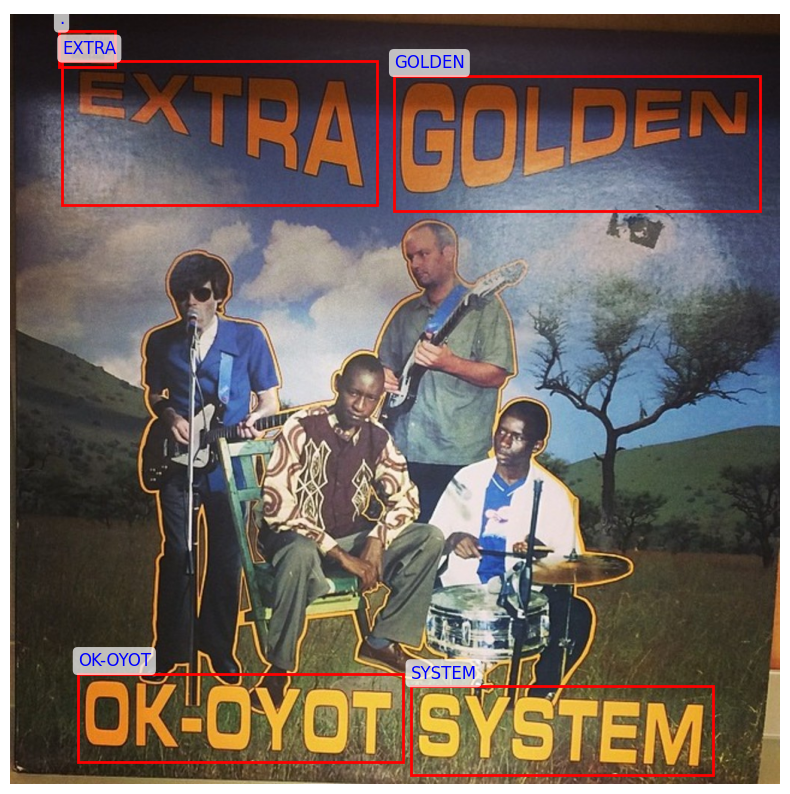

In [44]:
# Load Annotations (example: from parquet or JSON files)
annotation_file = "/content/unzipped_dataset/TextOCR_0.1_train.json"  # Adjust path as necessary
data_folder = "/content/unzipped_dataset/train_val_images/train_images"

# Load annotations from JSON
import json
with open(annotation_file, "r") as f:
    annotations = json.load(f)

# Select a sample image ID and path
sample_image_id = "f644219f560e3778"  # Replace with any valid image ID from your dataset
image_path = os.path.join(data_folder, f"{sample_image_id}.jpg")

# Get annotations for the selected image
image_annotations = [
    annotations["anns"][ann_id] for ann_id in annotations["imgToAnns"].get(sample_image_id, [])
]

# Define visualization function
def visualize_ground_truth(image_path, image_annotations):
    """
    Visualize the ground truth annotations (bounding boxes and text) on the image.
    """
    image = Image.open(image_path)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)

    for annotation in image_annotations:
        bbox = annotation["bbox"]  # [x, y, width, height]
        text = annotation["utf8_string"]

        # Draw bounding box
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor="red", facecolor="none"
        )
        ax.add_patch(rect)

        # Display text
        ax.text(
            bbox[0], bbox[1] - 10, text, fontsize=12, color="blue",
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", boxstyle="round,pad=0.3")
        )

    plt.axis("off")
    plt.show()

# Visualize the sample image with annotations
visualize_ground_truth(image_path, image_annotations)

*This image displays the ground truth annotations for text detection, where red bounding boxes highlight the text regions, and blue labels indicate the corresponding recognized text such as "EXTRA," "GOLDEN," "OK-OYOT," and "SYSTEM." The visual demonstrates accurate alignment of bounding boxes with the textual content in the image, validating the effectiveness of the annotation process for OCR.*

Resize Images to fit TrOCR Model

In [45]:
# Paths
output_folder = "/content/output_images"  # Folder with preprocessed images
resized_folder = "/content/resized_images"  # Folder for resized images
os.makedirs(resized_folder, exist_ok=True)  # Ensure resized folder exists

# Resize dimensions
RESIZE_DIM = (384, 384)

def resize_image(img_path, output_folder):
    """Check image readability and resize to specified dimensions."""
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None, None  # Skip unreadable images

    original_size = image.shape  # Original dimensions
    resized_image = Image.open(img_path).convert("RGB").resize(RESIZE_DIM)  # Resize using PIL
    resized_image.save(os.path.join(output_folder, os.path.basename(img_path)))  # Save resized image

    return original_size, resized_image.size

# Process and resize first 5 images
print("Processing and resizing images...")
for file in os.listdir(output_folder)[:5]:
    img_path = os.path.join(output_folder, file)
    original_size, resized_size = resize_image(img_path, resized_folder)
    if original_size and resized_size:
        print(f"Image: {file} | Original Size: {original_size} | Resized Size: {resized_size}")

print(f"Resized images are saved in '{resized_folder}'.")

Processing and resizing images...
Resized images are saved in '/content/resized_images'.


Initiate and Preprocess TcOCR Model

In [46]:
# Paths
data_folder = "/content/unzipped_dataset/train_val_images/train_images"
annotations_file = "/content/unzipped_dataset/TextOCR_0.1_train.json"

# Load annotations
with open(annotations_file, "r") as f:
    annotations = json.load(f)

# Prepare Image-Text Pairs
image_text_pairs = []
for img_id, metadata in annotations["imgs"].items():
    file_name = metadata["file_name"]
    img_path = os.path.join(data_folder, os.path.basename(file_name))
    if os.path.exists(img_path):
        text_annotations = [
            annotations["anns"][ann_id]["utf8_string"]
            for ann_id in annotations["imgToAnns"].get(img_id, [])
        ]
        full_text = " ".join(text_annotations)
        image_text_pairs.append({"image_path": img_path, "text": full_text})

# Shuffle and Split Data
random.shuffle(image_text_pairs)
train_data, temp_data = train_test_split(image_text_pairs, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Prepare Hugging Face Dataset
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)
test_dataset = Dataset.from_list(test_data)
dataset = DatasetDict({"train": train_dataset, "validation": val_dataset, "test": test_dataset})

print("Dataset preparation complete.")

Dataset preparation complete.


### Training and Validation

In [47]:
# Initialize Processor and Model
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

# Set Configurations
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id  # Start token for the decoder
model.config.pad_token_id = processor.tokenizer.pad_token_id  # Padding token
model.config.eos_token_id = processor.tokenizer.eos_token_id  # End-of-sequence token

# Optional: Configure maximum sequence length and beam search for generation
model.config.max_length = 128  # Max text length during decoding
model.config.num_beams = 4  # Beam search for better decoding

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def preprocess_data(batch):
    # Load images and convert to RGB
    images = [Image.open(x).convert("RGB") for x in batch["image_path"]]
    pixel_values = processor(images=images, return_tensors="pt").pixel_values

    # Tokenize text and prepare labels
    labels = processor.tokenizer(
        batch["text"],
        padding="max_length",
        max_length=128,
        truncation=True,
        return_tensors="pt"
    ).input_ids

    batch["pixel_values"] = pixel_values
    batch["labels"] = labels
    return batch

# Apply preprocessing
dataset = dataset.map(preprocess_data, batched=True)
dataset.set_format(type="torch", columns=["pixel_values", "labels"])

# Define Training Arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/trocr_model",  # Directory for saving the model
    evaluation_strategy="steps",  # Evaluate after a certain number of steps
    save_strategy="steps",  # Save the model after a certain number of steps
    per_device_train_batch_size=8,  # Batch size for training
    per_device_eval_batch_size=8,  # Batch size for evaluation
    predict_with_generate=True,  # Use generate method for predictions
    logging_dir="/content/logs",  # Directory for logs
    logging_steps=50,  # Log every 50 steps
    eval_steps=200,  # Evaluate every 200 steps
    save_steps=200,  # Save every 200 steps
    num_train_epochs=3,  # Number of epochs
    learning_rate=5e-5,  # Learning rate
    warmup_steps=500,  # Warmup steps
    weight_decay=0.01,  # Weight decay
    save_total_limit=3,  # Limit the number of checkpoints
    fp16=torch.cuda.is_available(),  # Use mixed precision if supported
    report_to="none"  # Avoid external logging (like WandB)
)

# Define Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=processor.feature_extractor,  # Use processor for tokenization
    data_collator=None  # Default data collation
)

# Start Training
print("Starting training...")
trainer.train()

# Save Final Model
model.save_pretrained("/content/trocr_model")
processor.save_pretrained("/content/trocr_model")
print("Model training and saving complete.")

# Evaluate the Model
print("Evaluating the model...")
metrics = trainer.evaluate(dataset["test"])
print("Evaluation Metrics:")
print(metrics)

print("Model initialization complete.")

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Map:   0%|          | 0/15244 [00:00<?, ? examples/s]

Map:   0%|          | 0/3267 [00:00<?, ? examples/s]

Map:   0%|          | 0/3267 [00:00<?, ? examples/s]

Starting training...
{'loss': 8.1048, 'grad_norm': 9.0010986328125, 'learning_rate': 4.6e-06, 'epoch': 0.026232948583420776}
{'loss': 2.7259, 'grad_norm': 6.599204063415527, 'learning_rate': 9.600000000000001e-06, 'epoch': 0.05246589716684155}
{'loss': 2.4678, 'grad_norm': 6.70832633972168, 'learning_rate': 1.4599999999999999e-05, 'epoch': 0.07869884575026233}
{'loss': 2.6958, 'grad_norm': 4.752913951873779, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.1049317943336831}
{'eval_loss': 2.330550193786621, 'eval_runtime': 85.8647, 'eval_samples_per_second': 38.048, 'eval_steps_per_second': 4.763, 'epoch': 0.1049317943336831}
{'loss': 2.5, 'grad_norm': 3.822147846221924, 'learning_rate': 2.46e-05, 'epoch': 0.1311647429171039}
{'loss': 2.4449, 'grad_norm': 4.428562164306641, 'learning_rate': 2.96e-05, 'epoch': 0.15739769150052466}
{'loss': 2.3022, 'grad_norm': 3.563816547393799, 'learning_rate': 3.46e-05, 'epoch': 0.18363064008394545}
{'loss': 2.1573, 'grad_norm': 3.7847089767456055, 

### Evaluation Metrics

In [ ]:
# Function to preprocess data and retain `image_path`
def preprocess_data_with_path(batch):
    images = [Image.open(x).convert("RGB") for x in batch["image_path"]]
    pixel_values = processor(images=images, return_tensors="pt").pixel_values

    labels = processor.tokenizer(
        batch["text"],
        padding="max_length",
        max_length=128,
        truncation=True,
        return_tensors="pt",
    ).input_ids

    batch["pixel_values"] = pixel_values
    batch["labels"] = labels
    return batch

# Ensure `image_path` is retained in the dataset
dataset = dataset.map(preprocess_data_with_path, batched=True)
dataset.set_format(type="torch", columns=["pixel_values", "labels", "image_path", "text"])

# Function to generate predictions
def generate_predictions(batch):
    images = [Image.open(x).convert("RGB") for x in batch["image_path"]]
    pixel_values = processor(images=images, return_tensors="pt").pixel_values.to(device)

    outputs = model.generate(pixel_values, max_length=128, num_beams=4)
    predictions = processor.tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return predictions

# Function to calculate evaluation metrics
def calculate_metrics(dataset):
    ground_truths = []
    predictions = []

    dataloader = DataLoader(dataset, batch_size=8)
    for batch in tqdm(dataloader, desc="Evaluating"):
        batch_predictions = generate_predictions(batch)
        predictions.extend(batch_predictions)
        ground_truths.extend(batch["text"])

    cer_score = cer(ground_truths, predictions)
    wer_score = wer(ground_truths, predictions)

    return cer_score, wer_score, ground_truths, predictions

# Evaluate on the test dataset
print("Evaluating the model on the test dataset...")
cer_score, wer_score, ground_truths, predictions = calculate_metrics(dataset["test"])

# Display results
print("\nEvaluation Metrics:")
print(f"Character Error Rate (CER): {cer_score:.3f}")
print(f"Word Error Rate (WER): {wer_score:.3f}")

# Save predictions for further analysis
results_df = pd.DataFrame({
    "Ground Truth": ground_truths,
    "Prediction": predictions
})
results_csv_path = "/content/trocr_predictions.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"Predictions saved to {results_csv_path}")

Map:   0%|          | 0/15244 [00:00<?, ? examples/s]